In [2]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from datetime import datetime

In [28]:
# dataset = pd.read_csv("Data/train.csv")  # Full dataset from Kaggle

dataset = pd.read_csv("Data/NYCTaxiFares.csv")  # Smaller subset of actual data to allow 
                                                # most computers to run dataset and model effectively

In [29]:
dataset.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [30]:
len(dataset)

120000

In [31]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


In [32]:
dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])
dataset['hour'] = dataset['pickup_datetime'].dt.hour
dataset['am_pm'] = np.where(dataset['hour']<12,'am','pm')
dataset['day_of_week'] = dataset['pickup_datetime'].dt.dayofweek  # from 0 (monday) to 6 (sunday)
dataset['weekday_weekend'] = np.where(dataset['day_of_week']<5,'weekday','weekend')

In [33]:
dataset.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,am_pm,day_of_week,weekday_weekend
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,8,am,0,weekday
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,15,pm,5,weekend
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,11,am,5,weekend
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,21,pm,6,weekend
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2,am,5,weekend


In [34]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians

def distance(lat1, long1, lat2, long2):
    location1 = [radians(lat1), radians(long1)]
    location2 = [radians(lat2), radians(long2)]
    result = haversine_distances([location1,location2]) * 6371000/1000  # multiply by earth radius
    
    return max(result[0])

In [35]:
distance(1.28927550956,103.851328261,1.30258712298,103.825826697)  # Distance from City Hall MRT to Orchard MRT in km

3.1980793177511013

In [36]:
dataset['distance'] = dataset.apply(lambda row: distance(row.pickup_latitude,row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude),axis=1)

In [37]:
dataset.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,am_pm,day_of_week,weekday_weekend,distance
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,8,am,0,weekday,2.126312
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,15,pm,5,weekend,1.392307
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,11,am,5,weekend,3.326763
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,21,pm,6,weekend,1.864129
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,2,am,5,weekend,7.231321


In [38]:
# Note: Passenger count should not affect fare price, hence not included 
cat= ['am_pm','weekday_weekend','day_of_week']  
cont = ['pickup_longitude',  # Maybe some locations are prone to traffic jams --> Higher taxi meter fare?
        'pickup_latitude',
        'dropoff_longitude',
        'dropoff_latitude',
        'hour',
        'distance']
label = ['fare_amount']

In [39]:
for item in cat:
    dataset[item] = dataset[item].astype('category')

cat_stack = np.stack([dataset[item].cat.codes.values for item in cat], axis = 1)
cat_stack = torch.tensor(cat_stack, dtype = torch.int32)
cat_stack

tensor([[0, 0, 0],
        [1, 1, 5],
        [0, 1, 5],
        ...,
        [1, 1, 6],
        [0, 0, 1],
        [1, 1, 5]], dtype=torch.int32)

In [40]:
cont_stack = np.stack([dataset[item].values for item in cont], axis = 1)
cont_stack = torch.tensor(cont_stack, dtype = torch.float32)
cont_stack

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   8.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,  15.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,  11.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,  18.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   8.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,  16.0000,   1.4274]])

In [41]:
label = torch.tensor(dataset[label].values, dtype = torch.float32)
label

tensor([[ 6.5000],
        [ 6.9000],
        [10.1000],
        ...,
        [12.5000],
        [ 4.9000],
        [ 5.3000]])

In [42]:
cat_sizes = [len(dataset[item].unique()) for item in cat] 
cat_embed_sizes = [(size, (size+1)//2) for size in cat_sizes]
cat_embed_sizes  # Category size and corresponding dimensions used for embedding layer

[(2, 1), (2, 1), (7, 4)]

In [43]:
class TaxiANN(nn.Module):
    
    def __init__(self, embed_sizes, n_cont, layers, n_output, dropout=0.5):
        """
        Sets up categorical input embedding, continuous input normalizing, and additional layers as required.
        
        Args:
            embed_sizes (:obj: `list` of :obj: `(int,int)`): List of tuples containing number of categories 
                and how many dimensions to embed into, for each categorical input
            n_cont (int): Number of continuous inputs in total
            layers (:obj: `list` of :obj: `int`): List of values for number of input nodes of additional layers
            n_output (int): Number of output nodes (eg labels)
            dropout (int): p value for dropout layer (0 <= p <= 1)
            
        """
        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(i,j) for i,j in embed_sizes])
        self.emb_drop = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(n_cont)
        
        n_embed = sum([j for _,j in embed_sizes])
        n_in = n_embed + n_cont
        
        layer_list = []
        for layer in layers:
            layer_list.append(nn.Linear(n_in,layer))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(layer))
            layer_list.append(nn.Dropout(dropout))
            n_in = layer
            
        layer_list.append(nn.Linear(layers[-1],n_output))
        
        self.layers = nn.Sequential(*layer_list)
        
    def forward(self, x_cat, x_cont):
        """
        Forward method.
        
        Args:
            x_cat (:obj: `tensor`): Input categorical data
            x_cont (:onj: `tensor`): Input continuous data
        """
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))       # Obtain embedding of category using corresponding embedding layer
                                                   # and stores it in embeddings list
                
        x = torch.cat(embeddings, dim=1)       # For each record, concatenate embedded categorical features onto 
                                               # single row
        x = self.emb_drop(x)

        x_cont = self.batch_norm(x_cont)
        x = torch.cat([x, x_cont], dim=1)      # For each record, concatenate categorical and continuous features 
                                               # onto single row
        x = self.layers(x)
        return x
        

In [104]:
model = TaxiANN(cat_embed_sizes,len(cont),[150,100],1,dropout=0.4)

In [105]:
model

TaxiANN(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(2, 1)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (batch_norm): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=150, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=150, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [106]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [107]:
train_prop = 0.8
train_cat = cat_stack[:int(train_prop*len(cat_stack))]
test_cat = cat_stack[int(train_prop*len(cat_stack)):]

train_cont = cont_stack[:int(train_prop*len(cont_stack))]
test_cont = cont_stack[int(train_prop*len(cont_stack)):]

train_label = label[:int(train_prop*len(label))]
test_label = label[int(train_prop*len(label)):]

In [108]:
start_time = datetime.now()

epochs = 600
loss_list = []

for i in range(epochs):
    pred = model(train_cat, train_cont)
    loss = torch.sqrt(criterion(pred, train_label))
    loss_list.append(loss.detach().numpy())

    if i%10 == 0:
        print(f'Epoch {i+1:3}: Loss value is {loss:10.8f}')
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'Epoch {i+1:3}: Loss value is {loss:10.8f}')    
print(f'Duration taken: {datetime.now()-start_time}')

Epoch   1: Loss value is 12.69050789
Epoch  11: Loss value is 9.64957333
Epoch  21: Loss value is 8.02846527
Epoch  31: Loss value is 5.08592415
Epoch  41: Loss value is 4.06750822
Epoch  51: Loss value is 3.58472347
Epoch  61: Loss value is 3.52528048
Epoch  71: Loss value is 3.42127585
Epoch  81: Loss value is 3.36014795
Epoch  91: Loss value is 3.33518100
Epoch 101: Loss value is 3.32123852
Epoch 111: Loss value is 3.28959584
Epoch 121: Loss value is 3.28578019
Epoch 131: Loss value is 3.29360008
Epoch 141: Loss value is 3.27064919
Epoch 151: Loss value is 3.26495147
Epoch 161: Loss value is 3.25487280
Epoch 171: Loss value is 3.25507903
Epoch 181: Loss value is 3.24058366
Epoch 191: Loss value is 3.24226332
Epoch 201: Loss value is 3.22978711
Epoch 211: Loss value is 3.22463822
Epoch 221: Loss value is 3.21567726
Epoch 231: Loss value is 3.23900676
Epoch 241: Loss value is 3.21161366
Epoch 251: Loss value is 3.22201252
Epoch 261: Loss value is 3.20715809
Epoch 271: Loss value is 3.

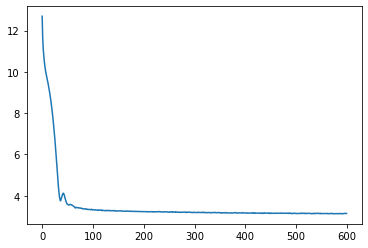

In [110]:
plot.plot(range(epochs),loss_list)

In [111]:
with torch.no_grad():
    pred = model.forward(test_cat, test_cont)
    loss = torch.sqrt(criterion(pred,test_label))
    
print(f'RMSE value of {loss}')

RMSE value of 3.26261043548584


In [112]:
torch.save(model.state_dict(),'TaxiANN.pt')

## Prediction on Kaggle test set

In [113]:
test_set = pd.read_csv("Data/NYCTaxiFares_test.csv")

In [116]:
test_set['pickup_datetime'] = pd.to_datetime(test_set['pickup_datetime'])
test_set['hour'] = test_set['pickup_datetime'].dt.hour
test_set['am_pm'] = np.where(test_set['hour']<12,'am','pm')
test_set['day_of_week'] = test_set['pickup_datetime'].dt.dayofweek  # from 0 (monday) to 6 (sunday)
test_set['weekday_weekend'] = np.where(test_set['day_of_week']<5,'weekday','weekend')    
test_set['distance'] = test_set.apply(lambda row: distance(row.pickup_latitude,row.pickup_longitude,row.dropoff_latitude,row.dropoff_longitude),axis=1)    

for item in cat:
    test_set[item] = test_set[item].astype('category')
    
cat_stack = np.stack([test_set[item].cat.codes.values for item in cat], axis = 1)
cat_stack = torch.tensor(cat_stack, dtype = torch.int32)

cont_stack = np.stack([test_set[item].values for item in cont], axis = 1)
cont_stack = torch.tensor(cont_stack, dtype = torch.float32)

with torch.no_grad():
    pred = model.forward(cat_stack, cont_stack)

In [118]:
test_set.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,am_pm,day_of_week,weekday_weekend,distance
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24+00:00,-73.973320,40.763805,-73.981430,40.743835,1,13,pm,1,weekday,2.323260
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24+00:00,-73.986862,40.719383,-73.998886,40.739201,1,13,pm,1,weekday,2.425353
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44+00:00,-73.982524,40.751260,-73.979654,40.746139,1,11,am,5,weekend,0.618628
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12+00:00,-73.981160,40.767807,-73.990448,40.751635,1,21,pm,5,weekend,1.961033
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12+00:00,-73.966046,40.789775,-73.988565,40.744427,1,21,pm,5,weekend,5.387301


In [127]:
pd.DataFrame({'key':test_set['key'],'fare_amount':pred.numpy().squeeze()}).to_csv('submission.csv',index=False)

## Results

Score obtained: 5.24796 (The lower the better)

<img src="Images/Kaggle score.jpg" height="400" width="450"/>

Average score on Kaggle leaderboard: 9.40949

<img src="Images/Average.jpg" height="400" width="450"/>

Further improvements could be made by using the full dataset, where a desktop computer (and a GPU) may have to be used to speed up training time. Model hyperparameters could be fine-tuned as well.